In [1]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.utils import to_undirected
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.nn import GraphSAGE
from torch_geometric.data import Data
import time
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.cluster import KMeans

from torch_geometric.nn.models.basic_gnn import BasicGNN
from typing import Any, Callable, Dict, Final, List, Optional, Tuple, Union
from torch_geometric.nn.conv import MessagePassing, GraphConv

In [2]:
from helpers import *

# Load Nodes Data

In [35]:
# BigQuery api client
bq = bigquery.Client(location="US")
# load nodes tables into dataframes
node_user, node_user_day, node_content, node_entities = load_nodes_tables(bq, local=True)

Read from local csv files.


In [36]:
node_user

,user_node_id,nodeType,subId,E1_Code,TenureDays,churned
0,197,U,74442728887200EE,53,365,0
1,1660,U,74442789887200EE,2,365,1
2,653,U,74443467887200EE,8,365,0
3,928,U,74444999887200EE,8,365,0
4,1156,U,74445750887200EE,6,365,0
...,...,...,...,...,...,...
1676,1651,U,75488017887200EE,6,6,0
1677,241,U,75488251887200EE,9,359,0
1678,69,U,75488461887200EE,6,5,1
1679,343,U,75488517887200EE,4,18,0


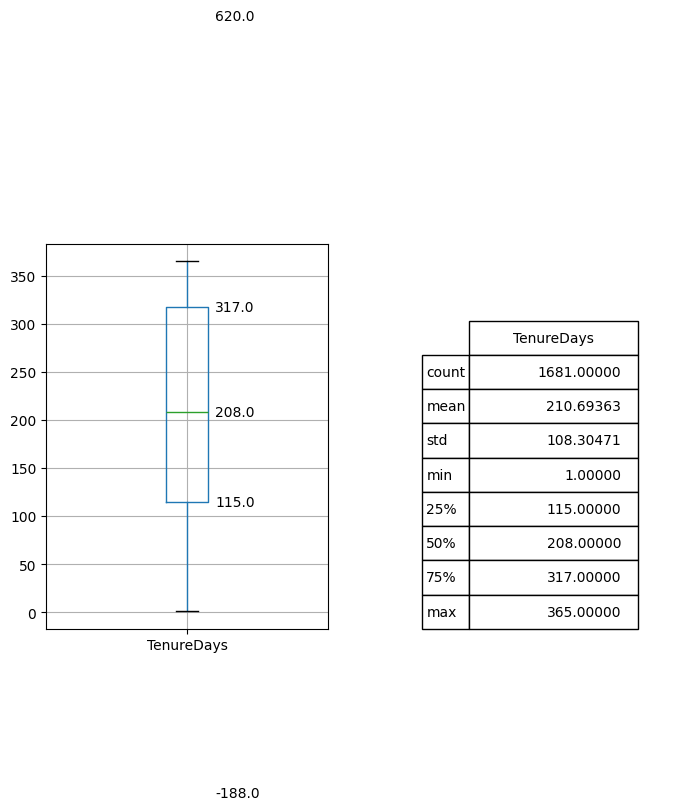

In [5]:
num_boxPlot_desc(node_user, 'TenureDays')

In [37]:
node_user[node_user.TenureDays<=365].churned.mean()  #.user_node_id.nunique() = 1681

0.09518143961927424

In [14]:
node_user[node_user.TenureDays>365].churned.mean()    #.user_node_id.nunique() = 7616

0.04372373949579832

In [38]:
node_user = node_user.sort_values(by=['user_node_id'], ascending=True).reset_index(drop=True)
node_user[['user_node_id', 'E1_Code', 'churned']] = node_user[['user_node_id', 'E1_Code', 'churned']].astype('int64')
node_user_day = node_user_day.sort_values(by=['user_day_node_id'], ascending=True).reset_index(drop=True)
node_user_day['user_day_node_id'] = node_user_day.user_day_node_id.astype('int64')
node_content = node_content.sort_values(by=['content_node_id'], ascending=True).reset_index(drop=True)
node_content['content_node_id'] = node_content.content_node_id.astype('int64')
node_entities = node_entities.sort_values(by=['entity_node_id'], ascending=True).reset_index(drop=True)
node_entities['entity_node_id'] = node_entities.entity_node_id.astype('int64')
node_content = pd.get_dummies(data=node_content, columns=['content_type', 'content_protection_status'])

In [39]:
print('Users', node_user.shape[0], 'UserDay', node_user_day.shape[0], 'Contents', node_content.shape[0], 'Entities', node_entities.shape[0])
display(node_user.head(3))
display(node_user_day.head(3))
display(node_content.head(3))
display(node_entities.head(3))

Users 1681 UserDay 25479 Contents 8478 Entities 5099


,user_node_id,nodeType,subId,E1_Code,TenureDays,churned
0,0,U,75276094887200EE,142,95,0
1,1,U,74739525887200EE,8,290,0
2,2,U,75405357887200EE,9,40,0


,user_day_node_id,nodeType,subDayId
0,0,UT,75276094887200EE2023-11-29
1,1,UT,74739525887200EE2023-11-21
2,2,UT,75405357887200EE2023-12-15


,content_node_id,nodeType,content_id,content_length,content_type_article,content_type_video,content_protection_status_free,content_protection_status_metered,content_protection_status_premium
0,0,C,3661891,523.0,1,0,1,0,0
1,1,C,9503357,1309.0,1,0,0,1,0
2,2,C,12546645,70.0,0,1,1,0,0


,entity_node_id,nodeType,entities
0,0,E,politicians
1,1,E,lyndon johnson
2,2,E,donald trump


In [40]:
content_fea = node_content[['content_length', 'content_type_article', 'content_type_video', 'content_protection_status_free', 
                            'content_protection_status_metered', 'content_protection_status_premium']].copy()
                            # 'content_protection_status_registered']].copy()     # 7 features
content_fea['node_type_u'], content_fea['node_type_ut'], content_fea['node_type_c'], content_fea['node_type_e'], content_fea['y'] = [0,0,1,0,-99]
content_fea = torch.from_numpy(content_fea.values).to(torch.float)
print(content_fea.shape)
content_fea[:3]

torch.Size([8478, 11])


tensor([[ 5.2300e+02,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         -9.9000e+01],
        [ 1.3090e+03,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         -9.9000e+01],
        [ 7.0000e+01,  0.0000e+00,  1.0000e+00,  1.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         -9.9000e+01]])

In [41]:
user_fea = pd.DataFrame(np.zeros((node_user.shape[0], 5), dtype=int), columns=['padding1', 'padding2','padding3','padding4','padding5']) #,'padding6'])
user_fea['E1_Code']=node_user.E1_Code
user_fea['node_type_u'], user_fea['node_type_ut'], user_fea['node_type_c'], user_fea['node_type_e'] = [1,0,0,0]
user_fea['y']=node_user.churned
user_fea = torch.from_numpy(user_fea.values).to(torch.float)
print(user_fea.shape)
user_fea[:3]

torch.Size([1681, 11])


tensor([[  0.,   0.,   0.,   0.,   0., 142.,   1.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   8.,   1.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   9.,   1.,   0.,   0.,   0.,   0.]])

In [42]:
ut_fea = pd.DataFrame(np.zeros((node_user_day.shape[0], 6), dtype=int), columns=['padding1', 'padding2','padding3','padding4','padding5','padding6']) #,'padding7'])
ut_fea['node_type_u'], ut_fea['node_type_ut'], ut_fea['node_type_c'], ut_fea['node_type_e'], ut_fea['y'] = [0,1,0,0,-99]
ut_fea = torch.from_numpy(ut_fea.values).to(torch.float)
print(ut_fea.shape)
ut_fea[:3]

torch.Size([25479, 11])


tensor([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0., -99.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0., -99.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0., -99.]])

In [43]:
entity_fea = pd.DataFrame(np.zeros((node_entities.shape[0], 6), dtype=int), columns=['padding1', 'padding2','padding3','padding4','padding5','padding6']) #,'padding7'])
entity_fea['node_type_u'], entity_fea['node_type_ut'], entity_fea['node_type_c'], entity_fea['node_type_e'], entity_fea['y'] = [0,0,0,1,-99]
entity_fea = torch.from_numpy(entity_fea.values).to(torch.float)
print(entity_fea.shape)
entity_fea[:3]

torch.Size([5099, 11])


tensor([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1., -99.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1., -99.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1., -99.]])

In [44]:
# Nodes combined
combined_nodes_features = torch.cat((user_fea, ut_fea, content_fea, entity_fea), dim=0)
print(combined_nodes_features.shape)
combined_nodes_features[:3]

torch.Size([40737, 11])


tensor([[  0.,   0.,   0.,   0.,   0., 142.,   1.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   8.,   1.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   9.,   1.,   0.,   0.,   0.,   0.]])

# Load Edge Indices data

In [45]:
# load edge indices into dataframes
u_to_ut, ut_to_c, c_to_e, e_to_e = load_edge_indices(bq, local=True)
u_to_ut = u_to_ut.astype('int64')
ut_to_c = ut_to_c.astype('int64')
c_to_e = c_to_e.astype('float32')
c_to_e[['edge_from', 'edge_to']] = c_to_e[['edge_from', 'edge_to']].astype('int64')
e_to_e = e_to_e.astype('int64')
print(u_to_ut.shape, ut_to_c.shape, c_to_e.shape, e_to_e.shape)

Read from local csv files.
(25479, 2) (87015, 2) (58596, 3) (4929, 2)


In [156]:
np.random.uniform(size=10)

array([0.38031171, 0.19393099, 0.27301249, 0.18890813, 0.73454789,
       0.30790954, 0.88246901, 0.72089034, 0.41111468, 0.47452485])

In [47]:
# Assign global node ids and combine the 2 edge index tables
# This is necessary because PyG LinkNeighborLoader does not yet support graphs with multiple edge types.

user_node_id_offset = node_user.shape[0]
ut_node_id_offset = node_user.shape[0] + node_user_day.shape[0]
content_node_id_offset = node_user.shape[0] + node_user_day.shape[0] + node_content.shape[0]

u_to_ut['src'] = u_to_ut['edge_from']
u_to_ut['trg'] = u_to_ut['edge_to'] + user_node_id_offset
u_to_ut['weight'] = np.ones((u_to_ut.shape[0], 1), dtype=np.float32)
u_to_ut = u_to_ut.drop(columns=['edge_from', 'edge_to'])

ut_to_c['src'] = ut_to_c['edge_from'] + user_node_id_offset
ut_to_c['trg'] = ut_to_c['edge_to'] + ut_node_id_offset
ut_to_c['weight'] = np.ones((ut_to_c.shape[0], 1), dtype=np.float32)
ut_to_c = ut_to_c.drop(columns=['edge_from', 'edge_to'])

c_to_e['src'] = c_to_e['edge_from'] + ut_node_id_offset
c_to_e['trg'] = c_to_e['edge_to'] + content_node_id_offset
c_to_e['weight'] = c_to_e['relevanceScore'].clip(0., 1.)
c_to_e = c_to_e.drop(columns=['edge_from', 'edge_to', 'relevanceScore'])

e_to_e['src'] = e_to_e['edge_from'] + content_node_id_offset
e_to_e['trg'] = e_to_e['edge_to'] + content_node_id_offset
e_to_e['weight'] = np.ones((e_to_e.shape[0], 1), dtype=np.float32)
e_to_e = e_to_e.drop(columns=['edge_from', 'edge_to'])

# Combine the edges
combined_edges = pd.concat([u_to_ut, ut_to_c, c_to_e, e_to_e])
print(combined_edges.shape)
assert max(combined_edges['trg'].values) == node_user.shape[0] + node_user_day.shape[0] + node_content.shape[0] + node_entities.shape[0] - 1

(176019, 3)


In [48]:
# construct `edge_index` in COO format
src = torch.from_numpy(combined_edges['src'].values)
trg = torch.from_numpy(combined_edges['trg'].values)
edge_index = torch.stack([src, trg], dim=0)
edge_weight = torch.from_numpy(combined_edges['weight'].values)
print(edge_index.shape)
assert edge_index.size() == (2, u_to_ut.shape[0]+ut_to_c.shape[0]+c_to_e.shape[0]+e_to_e.shape[0])
assert edge_index.size()[1] == edge_weight.size()[0]

torch.Size([2, 176019])


In [49]:
edge_index, edge_weight = to_undirected(edge_index, edge_weight)

# Train test split

In [111]:
total_user = node_user.shape[0]
test_user = int(total_user*0.1)
y_col = 10
print('total num users', total_user, 'test set users', test_user)

total num users 1681 test set users 168


In [112]:
print('Churn rate before split', combined_nodes_features[:total_user, y_col].mean().item())
combined_nodes_features[:total_user, y_col].unique()    # original user labels, just 0, 1

Churn rate before split 0.09518144279718399


tensor([0., 1.])

In [113]:
# reserve 10% users as test set. Keep global user_node_id in test_idx
test_idx = torch.randperm(total_user)[:test_user]         # ramdom permutation then 10% node_id
print(len(test_idx))
test_set = combined_nodes_features[test_idx, :]

168


In [114]:
print('test set num_users: ', test_set.size(), 
      '\nchurn rate: ', test_set[:,y_col].mean(), 
      '\ntotal num_users: ', combined_nodes_features[:total_user].size(),
      '\nchurn rate: ', combined_nodes_features[:total_user, y_col].mean())

test set num_users:  torch.Size([168, 11]) 
churn rate:  tensor(0.0952) 
total num_users:  torch.Size([1681, 11]) 
churn rate:  tensor(0.0952)


In [115]:
# mask original user labels to be -99. for test set
combined_nodes_features[test_idx, 10] = -99.    
combined_nodes_features[:node_user.shape[0], 10].unique()    # after mask, test set users are labeled as -99.

tensor([-99.,   0.,   1.])

# Modeling

## Data Loader

In [116]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

data = Data(x=combined_nodes_features[:, :10], y=combined_nodes_features[:, 10], #.to(torch.int64),
            edge_index=edge_index, edge_weight=edge_weight)
print(data.is_undirected())
data = data.to(device)
data

cuda
True


Data(x=[40737, 10], edge_index=[2, 352038], y=[40737], edge_weight=[352038])

In [117]:
data.edge_weight.unique()

tensor([1.1658e-05, 1.1659e-05, 1.5543e-05,  ..., 9.9956e-01, 9.9992e-01,
        1.0000e+00], device='cuda:0')

In [118]:
# for mini batch training
train_loader = LinkNeighborLoader(
    data,
    batch_size=10000, 
    shuffle=True,
    neg_sampling_ratio=1.0,
    num_neighbors=[20, 20],
)

In [119]:
sample = next(iter(train_loader)).to(device)
print(sample)

Data(x=[39610, 10], edge_index=[2, 249348], y=[39610], edge_weight=[249348], n_id=[39610], e_id=[249348], num_sampled_nodes=[3], num_sampled_edges=[2], input_id=[10000], edge_label_index=[2, 20000], edge_label=[20000])


## GraphSAGE + Fully Connect NN

In [120]:
class GraphSAGE(BasicGNN):
    supports_edge_weight: Final[bool] = False
    supports_edge_attr: Final[bool] = False
    supports_norm_batch: Final[bool]

    def init_conv(self, in_channels: Union[int, Tuple[int, int]],
                  out_channels: int, **kwargs) -> MessagePassing:
        return GraphConv(in_channels, out_channels, aggr='add', **kwargs)    

In [121]:
class FullyConnectNN(nn.Module):
  def __init__(self):
    super().__init__()

    input_size = 64          # same as SAGE hidden_channels 64
    hidden_sizes = [64, 64]  # 1st and 2nd hidden layer size
    output_size = 1          # binary classifier, so output layer size is 1
    self.net = nn.Sequential(
          nn.Linear(input_size, hidden_sizes[0]),       # layer 1
          nn.ReLU(),
          nn.Linear(hidden_sizes[0], hidden_sizes[1]),   # layer 2
          nn.ReLU(),
          nn.Linear(hidden_sizes[1], output_size))
          # nn.Sigmoid())      # Output                   


  def forward(self, x):
    return self.net(x)

## Train-Val-Test

In [122]:
def train(model1, model2, optimizer, train_loader, device, loss_weight=(0.5, 0.5)):  # user_node_id_offset, data,

    model1.train()
    model2.train()
    num_batches = 0
    ep_loss1, ep_loss2 = 0.0, 0.0
    ep_pred_sage = torch.empty((0), dtype=torch.float32).to(device)
    ep_pred = torch.empty((0), dtype=torch.float32).to(device)
    ep_label = torch.empty((0), dtype=torch.int64).to(device)
    
    for batch in train_loader:
        loss1, loss2 = 0.0, 0.0
        batch = batch.to(device)
        optimizer.zero_grad()
    
        # SAGE
        h = model1(batch.x, batch.edge_index) #, batch.edge_weight)
        h_src = h[batch.edge_label_index[0]]
        h_dst = h[batch.edge_label_index[1]]
        pred = (h_src * h_dst).sum(dim=-1)
        loss1 = F.binary_cross_entropy_with_logits(pred, batch.edge_label)/10000.0
    
        # user nodes embeddings and y in the batch 
        mask = batch.y != -99.                          # only train set user nodes in the batch
        mask = torch.reshape(mask.nonzero(), (-1,))
        fea = h[mask, :]                                # user nodes' embeddings
        label = batch.y[mask]                           # labels of users
        assert fea.size()[0] == label.size()[0]
        assert label.max() == 1
        
        if mask.shape[0] > 0:                           # loss2 when message passing involves user nodes
            # Fully Connect NN
            train_pred = model2(fea)
            train_pred = torch.reshape(train_pred, (-1,))
            loss2 = F.binary_cross_entropy_with_logits(train_pred, label, pos_weight=torch.Tensor([1.5]).to(device))
            loss = loss_weight[0] * loss1 + loss_weight[1] * loss2
            # loss = loss2
        else:                                           # no loss2 when message passing involve none user nodes
            loss = loss1
            # continue
    
        loss.backward()
        optimizer.step()

        num_batches += 1
        ep_loss1 += loss1
        ep_loss2 += loss2
        # ep_pred_sage = torch.cat((ep_pred_sage, pred))
        # ep_pred = torch.cat((ep_pred, train_pred))
        # ep_label = torch.cat((ep_label, label.to(torch.int64)))

    return ep_loss1/num_batches, ep_loss2/num_batches, ep_pred  # loss  # total_loss / data.num_nodes   ep_pred_sage, 

In [124]:
model1 = GraphSAGE(
    data.num_node_features,
    hidden_channels=64,
    num_layers=2,
).to(device)
model2 = FullyConnectNN().to(device)
optimizer = torch.optim.Adam(model1.parameters(), lr=0.01)
last_layer = nn.Sigmoid()

# Training loop
times = []
for epoch in range(1, 100):
    start = time.time()
    ep_loss1, ep_loss2, ep_pred = train(model1, model2, optimizer, train_loader, device, loss_weight=(0.01, 0.99))   # ep_pred_sage, 
    print(f'Epoch: {epoch:03d}, AvgLoss1: {ep_loss1:.4f}, AvgLoss2: {ep_loss2:.4f}')
    # ep_pred_sage = last_layer(ep_pred_sage)
    # ep_pred = last_layer(ep_pred)
    # print(f'\tSage pred min: {ep_pred_sage.min().item():.4f}, max: {ep_pred_sage.max().item():.4f}, mean: {ep_pred_sage.mean().item():.4f}')
    # print(f'\tFC pred min: {ep_pred.min().item():.4f}, max: {ep_pred.max().item():.4f}, mean: {ep_pred.mean().item():.4f}\n')
    # val process
    times.append(time.time() - start)
    
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

Epoch: 001, AvgLoss1: 3316.5947, AvgLoss2: 10.4074
Epoch: 002, AvgLoss1: 192.5896, AvgLoss2: 1.8819
Epoch: 003, AvgLoss1: 81.1322, AvgLoss2: 0.8282
Epoch: 004, AvgLoss1: 43.9975, AvgLoss2: 0.5798
Epoch: 005, AvgLoss1: 7.6443, AvgLoss2: 0.6276
Epoch: 006, AvgLoss1: 8.4146, AvgLoss2: 0.4742
Epoch: 007, AvgLoss1: 9.4371, AvgLoss2: 0.4935
Epoch: 008, AvgLoss1: 10.7102, AvgLoss2: 0.5639
Epoch: 009, AvgLoss1: 4.8506, AvgLoss2: 0.4412
Epoch: 010, AvgLoss1: 0.7200, AvgLoss2: 0.4124
Epoch: 011, AvgLoss1: 0.4455, AvgLoss2: 0.4101
Epoch: 012, AvgLoss1: 0.3727, AvgLoss2: 0.4088
Epoch: 013, AvgLoss1: 0.3424, AvgLoss2: 0.4069
Epoch: 014, AvgLoss1: 0.3204, AvgLoss2: 0.4073
Epoch: 015, AvgLoss1: 0.3004, AvgLoss2: 0.4070
Epoch: 016, AvgLoss1: 0.2828, AvgLoss2: 0.4062
Epoch: 017, AvgLoss1: 0.2702, AvgLoss2: 0.4076
Epoch: 018, AvgLoss1: 0.2651, AvgLoss2: 0.4073
Epoch: 019, AvgLoss1: 0.2541, AvgLoss2: 0.4068
Epoch: 020, AvgLoss1: 0.2368, AvgLoss2: 0.4050
Epoch: 021, AvgLoss1: 0.2297, AvgLoss2: 0.4093
Epoc

In [125]:
# Save the trained model
save_model(model1, 'gnn_model.pt')
save_model(model2, 'fcnn_model.pt')

In [126]:
load_model(model1, 'gnn_model.pt')
load_model(model2, 'fcnn_model.pt')

In [127]:
model1.eval()
ht = model1(data.x, data.edge_index, data.edge_weight)

fea_t = ht[test_idx, :]           # test set user nodes' embeddings
label_t = test_set[:, 10]         # test set original labels

In [128]:
model2.eval()
test_pred = model2(fea_t)

last_layer = nn.Sigmoid()
test_pred = last_layer(test_pred)
test_pred = torch.reshape(test_pred, (-1,)).to('cpu')

In [129]:
print(f'Test set Loss2: {F.binary_cross_entropy_with_logits(test_pred, label_t).item():.4f}')
        
print(f'Test set churn predition min: {test_pred.min().item():.4f}, max: {test_pred.max().item():.4f}, mean: {test_pred.mean().item():.4f}')

Test set Loss2: 0.7438
Test set churn predition min: 0.0012, max: 0.3954, mean: 0.1203


In [152]:
#threshold = 0.00000010
threshold = 0.09

print('Accuracy:' , ((test_pred>threshold) == label_t).sum().item(),
      ', TP:', torch.logical_and((test_pred>threshold) == label_t, label_t==1).sum().item(),
      ', TN:', torch.logical_and((test_pred>threshold) == label_t, label_t==0).sum().item())   
label_t = label_t.to(torch.int64)
print(binary_confusion_matrix(test_pred, label_t, threshold=threshold))
print(f'Test set F1: {binary_f1_score(test_pred, label_t, threshold=threshold).item():.4f}')

Accuracy: 67 , TP: 12 , TN: 55
tensor([[55, 97],
        [ 4, 12]])
Test set F1: 0.1920


In [154]:
threshold = 0.5
f1 = 0.0
for i in range(10000):
    ran_pred = torch.rand(len(label_t))     # random prediction
    
    # print('Accuracy:' , ((ran_pred>threshold) == label_t).sum().item(),
    #       ', TP:', torch.logical_and((ran_pred>threshold) == label_t, label_t==1).sum().item(),
    #       ', TN:', torch.logical_and((ran_pred>threshold) == label_t, label_t==0).sum().item())   

    # print(binary_confusion_matrix(ran_pred, label_t, threshold=threshold))
    f1 += binary_f1_score(ran_pred, label_t, threshold=threshold).item()

print(f'Random prediction F1: {f1/10000:.4f}')

Random prediction F1: 0.1603
